In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import json
import requests
import asyncio
import aiohttp
import nest_asyncio
import unicodedata

from bs4 import BeautifulSoup
from dotenv import load_dotenv
from joblib import dump
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import (
    BaggingRegressor,
    BaggingClassifier,
    RandomForestClassifier,
    RandomForestRegressor,
    StackingRegressor,
    StackingClassifier,
    VotingRegressor,
    VotingClassifier
)
from sklearn.linear_model import ElasticNet, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm.notebook import tqdm
from itertools import product

## Pipeline. Основные классы и методы для препроцессинга и регрессии

In [2]:
class DataFramePreprocess(BaseEstimator, TransformerMixin):
    def __init__(self, ingredients_file='data/ingredients.csv'):
        self.ingredients_file = ingredients_file
        self.ingredient_list = []
        pass

    def processed_cols_names(self, list_cols):
        new_list = []
    
        for item in list_cols:
            words = item.strip().split()
            processed_words = []
            
            for word in words:
                # Изменим условие на более специфичное
                if word.lower() == 'or':
                    break
                if '/' in word:
                    processed_word = word.split('/')[0]
                else:
                    processed_word = word

                if processed_word.strip():
                    processed_words.append(processed_word)

            new_item = ' '.join(processed_words)
            new_list.append(new_item)
    
        return new_list

    
    def fit(self, data, y=None):
        self.ingredient_list = pd.read_csv(self.ingredients_file)['ingredients'].tolist()
        return self
    
    def transform(self, data, y=None):
        #Выбираем ингридиенты
        selected_cols = ['title', 'rating'] + self.ingredient_list
        data = data[selected_cols] 

        #Удаляем дубликаты
        data = data.drop_duplicates(subset='title', keep='first')

        #Сокращаем кол-во признаков
        summary = data.describe().T[['std']]
        summary.sort_values(by='std', ascending=False, inplace=True)
        cols_to_del = summary.query('std < 0.07').index.tolist()
        data = data.drop(columns=cols_to_del)

        #Устанавливаем индекс и оставляем строки в которых не менее 1 игредиента
        data = data.set_index('title')
        mask = data.drop(columns=['rating']).sum(axis=1) > 0
        data = data[mask]

        #Обрабатываем названия признаков
        list_cols = data.columns.tolist()
        new_cols = self.processed_cols_names(list_cols)
        data.columns = new_cols
        return data

class MyFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, target_column):
        self.target_column = target_column
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['round_rating'] = np.floor(data['rating'] + 0.5).astype(int)
        rating_map = np.array(['bad', 'bad', 'so-so', 'so-so', 'great', 'great'])
        ratings_np = data['round_rating'].to_numpy()
        data['cat_rating'] = rating_map[ratings_np]
        
        targets_columns = ['rating', 'round_rating', 'cat_rating']
        y = data[self.target_column]
        X = data.drop(columns=targets_columns)
        return X, y

class TrainValidationTest(BaseEstimator, TransformerMixin):
    def fit(self, data, y=None):
        return self
    
    def transform(self, data):
        # data здесь будет кортежем (X, y)
        X, y = data
        
         # Разделение на train и test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=21, stratify=y_train)

        return X_train, X_valid, X_test, y_train, y_valid, y_test

## Загрузка датафрейма

In [3]:
data = pd.read_csv('data/epi_r.csv', encoding='utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 680 entries, title to turkey
dtypes: float64(679), object(1)
memory usage: 104.0+ MB


## Препроцессинг

In [4]:
preprocessing = DataFramePreprocess('data/ingredients.csv')
df = preprocessing.fit_transform(data)
df.shape

(17500, 178)

## Regression

In [5]:
class RegressionSelection:
    def __init__(self, grids: list, grid_dict: dict, cv: int = 3):
        self.grids = grids
        self.grid_dict = grid_dict
        self.cv = cv
        self.results = []
        self.best_model = None
        self.best_name = None


    def full_results(self, gs, model_name, X_valid, y_valid):

        best_cv_mse = -gs.best_score_
        best_cv_rmse = np.sqrt(best_cv_mse)

        val_pred = gs.best_estimator_.predict(X_valid)
        val_mse = mean_squared_error(y_valid, val_pred)
        val_rmse = np.sqrt(val_mse)

        self.results.append({
            "model": model_name,
            "best_params": gs.best_params_,
            "CV_MSE": best_cv_mse,
            "CV_RMSE": best_cv_rmse,
            "valid_MSE": val_mse,
            "valid_RMSE": val_rmse
        })

        print(f"Best params: {gs.best_params_}")
        print(f"Best CV MSE: {best_cv_mse:.4f}, RMSE: {best_cv_rmse:.4f}")
        print(f"Validation MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}\n")

        return val_rmse
    
    def choose(self, X_train, y_train, X_valid, y_valid):
        best_val_rmse = np.inf

        for idx, gs in enumerate(self.grids):
            model_name = self.grid_dict[idx]
            print(f"\nEstimator: {model_name}")

            gs.fit(X_train, y_train)

            results_df = pd.DataFrame(gs.cv_results_)
            results_df = results_df.sort_values(by="rank_test_score")
            params_df = results_df["params"].apply(pd.Series, dtype=object)
            full_df = pd.concat([params_df, results_df[["mean_test_score", "std_test_score", "rank_test_score"]]], axis=1)

            print(f"\nТоп-10 результатов GridSearch для {model_name}:")
            display(full_df.head(10))

            val_rmse = self.full_results(gs, model_name, X_valid, y_valid)

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                self.best_model = gs.best_estimator_
                self.best_name = model_name

        print(f"\nBest model on validation: {self.best_name} (Validation RMSE={best_val_rmse:.4f})")
        return self.best_model


    def best_results(self):
        df = pd.DataFrame(self.results)
        df_sorted = df.sort_values(by="valid_RMSE", ascending=True).reset_index(drop=True)
        return df_sorted

In [6]:
class FinalizeRegression:
    def __init__(self, model):
        self.model = model


    def final_score(self, X_train, y_train, X_test, y_test):
        """Оценка регрессионной модели по RMSE"""
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE of the final model on test is {rmse:.6f}")
        return rmse

### 1. Разделение на валидационную и тестовую выборки

In [7]:
# Создаем пайплайн с нужным таргетом
split_processing = Pipeline([
    ('feature_extractor', MyFeatureExtractor('rating')),
    ('data_splitter', TrainValidationTest())
])

# Теперь можно получить все датасеты сразу
X_train, X_valid, X_test, y_train, y_valid, y_test = split_processing.fit_transform(df)
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape), (X_test.shape, y_test.shape)

(((11200, 177), (11200,)), ((2800, 177), (2800,)), ((3500, 177), (3500,)))

### 2. Наивный RMSE на тесте

In [8]:
y_mean = np.mean(df['rating'])
y_pred_naive = np.full_like(y_test, fill_value=y_mean, dtype=float)

rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
print("Naive RMSE:", rmse_naive)

Naive RMSE: 1.304642172773666


### 3. Модели регрессии

In [9]:
n_jobs = 4
cv = 3


elastic_params = [{
    "alpha": [0.001, 0.01, 0.1, 1],      # сила регуляризации
    "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],        # баланс L1/L2
    "max_iter": [1000, 2000],
    "random_state": [21]
}]
gs_elastic = GridSearchCV(ElasticNet(), param_grid=elastic_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)


svr_params = [{
    "kernel": ["rbf"],  # выбран из 2х, также смотрела ["linear"]
    "C": [1, 5],  # [0.01, 0.1, 1, 1.5, 5, 10],
    "epsilon": [0.1, 1.0],  #  [0.001, 0.01, 0.1, 0.5, 1.0],
    "gamma": ["scale", "auto", 0.1]  # игнорируется при linear
}]
gs_svr = GridSearchCV(SVR(), param_grid=svr_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)


tree_params = [{
    'max_depth': [None, 3], # отобрано после перебора np.arange(1, 50)
    'criterion': ['mse'], #  выбран как лучший из ['mse', 'mae']
    'min_samples_leaf': [30, 50],  # [1, 2, 4, 10],
    # 'max_features': [None, 0.5, 0.7],    # при 177 фич: 177*0,5, 177*0.7 и т.д 
    'random_state': [21]
}]
gs_tree = GridSearchCV(DecisionTreeRegressor(), param_grid=tree_params, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)

In [10]:
grids = [gs_elastic, gs_svr, gs_tree]
grid_dict = {0: "ElasticNet", 1: "CVR", 2: "DecisionTree"}

selector = RegressionSelection(grids, grid_dict)
best_model_selector = selector.choose(X_train, y_train, X_valid, y_valid)


Estimator: ElasticNet

Топ-10 результатов GridSearch для ElasticNet:


,alpha,l1_ratio,max_iter,random_state,mean_test_score,std_test_score,rank_test_score
8,0.001,0.9,1000,21,-1.581875,0.013121,1
9,0.001,0.9,2000,21,-1.581875,0.013121,1
6,0.001,0.7,1000,21,-1.582620,0.013029,3
7,0.001,0.7,2000,21,-1.582620,0.013029,3
4,0.001,0.5,1000,21,-1.584028,0.013019,5
5,0.001,0.5,2000,21,-1.584028,0.013019,5
2,0.001,0.3,1000,21,-1.585895,0.012884,7
3,0.001,0.3,2000,21,-1.585895,0.012884,7
0,0.001,0.1,1000,21,-1.588371,0.012762,9
1,0.001,0.1,2000,21,-1.588371,0.012762,9


Best params: {'alpha': 0.001, 'l1_ratio': 0.9, 'max_iter': 1000, 'random_state': 21}
Best CV MSE: 1.5819, RMSE: 1.2577
Validation MSE: 1.5252, RMSE: 1.2350


Estimator: CVR

Топ-10 результатов GridSearch для CVR:


,C,epsilon,gamma,kernel,mean_test_score,std_test_score,rank_test_score
5,1,1.0,0.1,rbf,-1.604677,0.022541,1
10,5,1.0,auto,rbf,-1.605748,0.018199,2
3,1,1.0,scale,rbf,-1.623074,0.027025,3
4,1,1.0,auto,rbf,-1.646871,0.015923,4
11,5,1.0,0.1,rbf,-1.668110,0.027009,5
0,1,0.1,scale,rbf,-1.700291,0.041352,6
2,1,0.1,0.1,rbf,-1.715825,0.035054,7
8,5,0.1,0.1,rbf,-1.738695,0.042737,8
7,5,0.1,auto,rbf,-1.747034,0.019021,9
6,5,0.1,scale,rbf,-1.767711,0.030532,10


Best params: {'C': 1, 'epsilon': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV MSE: 1.6047, RMSE: 1.2668
Validation MSE: 1.5495, RMSE: 1.2448


Estimator: DecisionTree

Топ-10 результатов GridSearch для DecisionTree:


,criterion,max_depth,min_samples_leaf,random_state,mean_test_score,std_test_score,rank_test_score
1,mse,NaN,50,21,-1.610171,0.009228,1
0,mse,NaN,30,21,-1.619615,0.015705,2
2,mse,3.0,30,21,-1.620974,0.012012,3
3,mse,3.0,50,21,-1.623163,0.012665,4


Best params: {'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 50, 'random_state': 21}
Best CV MSE: 1.6102, RMSE: 1.2689
Validation MSE: 1.5699, RMSE: 1.2530


Best model on validation: ElasticNet (Validation RMSE=1.2350)


In [11]:
print(f"{'Итоговые результаты:':=^50}")
pd.set_option('display.max_colwidth', 500)
models = selector.best_results()
models

===============Итоговые результаты:===============


,model,best_params,CV_MSE,CV_RMSE,valid_MSE,valid_RMSE
0,ElasticNet,"{'alpha': 0.001, 'l1_ratio': 0.9, 'max_iter': 1000, 'random_state': 21}",1.581875,1.257726,1.525217,1.234997
1,CVR,"{'C': 1, 'epsilon': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}",1.604677,1.266759,1.549480,1.244781
2,DecisionTree,"{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 50, 'random_state': 21}",1.610171,1.268925,1.569890,1.252952


In [12]:
selector.best_model

ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=21)

In [13]:
best_model = selector.best_model

print('Final best model:', selector.best_name)
final = FinalizeRegression(best_model)
final_rmse = final.final_score(X_train, y_train, X_test, y_test)

Final best model: ElasticNet
RMSE of the final model on test is 1.247684


### 5. Ансамбли

### RandomForestRegressor

In [14]:
rf_params = [{
    "n_estimators": [90, 200],  # range(10, 100, 5)
    "max_depth": [9, 24],  # range(6, 20),
    'min_samples_split': [2],  # range(2,7),
    'min_samples_leaf': [5],  # range(2,7),
    'criterion': ['mse'],
    "bootstrap": [True],
    "random_state": [21]
}]

gs_rf = GridSearchCV(
    RandomForestRegressor(), 
    param_grid=rf_params, 
    scoring='neg_mean_squared_error', 
    cv=cv, 
    n_jobs=n_jobs
)

### VotingRegressor

In [15]:
def get_best_params(models_df, model_name):
    """
    Функция для получения параметров конкретной лучшей модели. 
    DF моделей можно получить на предыдущем шаге
    selector = RegressionSelection(grids, grid_dict)
    models = selector.best_results()
    """
    row = models_df[models_df['model'] == model_name].iloc[0]
    params = row['best_params']
    return params

In [16]:
elastic_best = ElasticNet(**get_best_params(models, "ElasticNet"))
svr_best = SVR(**get_best_params(models, "CVR"))
tree_best = DecisionTreeRegressor(**get_best_params(models, "DecisionTree"))


voting = VotingRegressor(estimators=[
    ('elastic_net', elastic_best),
    ('tree', tree_best),
    ('svr', svr_best)
])

voting_params = {
    "weights": [[1,1,1], [2,1,1], [1,2,1], [1,1,2]],
}

gs_voting = GridSearchCV(voting, param_grid=voting_params, scoring="neg_mean_squared_error", cv=cv, n_jobs=n_jobs)

### BaggingRegressor

In [17]:
bagging = BaggingRegressor(base_estimator=elastic_best, random_state=21)

bagging_params = {
    "n_estimators": [101, 150], # np.arange(1, 105, 5),
    # "max_samples": [0.5, 0.8, 1.0],
    'bootstrap': [True, False],
    'warm_start': [True, False]
}

gs_bagging = GridSearchCV(bagging, param_grid=bagging_params, scoring="neg_mean_squared_error", cv=cv, n_jobs=n_jobs)

### StackingRegressor

In [18]:
stacking = StackingRegressor(
    estimators=[
        ('elastic_net', elastic_best),
        ('svr', svr_best),
        ('tree', tree_best)
    ],
    final_estimator=Ridge(random_state=21, alpha=50)
)

stacking_params = {
    "passthrough": [True, False]
}

gs_stacking = GridSearchCV(stacking, param_grid=stacking_params, scoring="neg_mean_squared_error", cv=cv, n_jobs=n_jobs)

In [19]:
grids = [gs_bagging]
grid_dict = {

    0: "BaggingRegressor"
}

selector_ensemble = RegressionSelection(grids, grid_dict, cv=cv)
best_model = selector_ensemble.choose(X_train, y_train, X_valid, y_valid)


Estimator: BaggingRegressor

Топ-10 результатов GridSearch для BaggingRegressor:


,bootstrap,n_estimators,warm_start,mean_test_score,std_test_score,rank_test_score
4,False,101,True,-1.581875,0.013121,1
5,False,101,False,-1.581875,0.013121,1
6,False,150,True,-1.581875,0.013121,1
7,False,150,False,-1.581875,0.013121,1
2,True,150,True,-1.582392,0.012621,5
3,True,150,False,-1.582392,0.012621,5
0,True,101,True,-1.582530,0.012544,7
1,True,101,False,-1.582530,0.012544,7


Best params: {'bootstrap': False, 'n_estimators': 101, 'warm_start': True}
Best CV MSE: 1.5819, RMSE: 1.2577
Validation MSE: 1.5252, RMSE: 1.2350


Best model on validation: BaggingRegressor (Validation RMSE=1.2350)


In [20]:
grids = [gs_rf, gs_voting, gs_bagging, gs_stacking]
grid_dict = {
    0: "RandomForest",
    1: "VotingRegressor",
    2: "BaggingRegressor",
    3: "StackingRegressor",
}

selector_ensemble = RegressionSelection(grids, grid_dict, cv=cv)
best_model = selector_ensemble.choose(X_train, y_train, X_valid, y_valid)


Estimator: RandomForest

Топ-10 результатов GridSearch для RandomForest:


,bootstrap,criterion,max_depth,min_samples_leaf,min_samples_split,n_estimators,random_state,mean_test_score,std_test_score,rank_test_score
3,True,mse,24,5,2,200,21,-1.591154,0.014397,1
2,True,mse,24,5,2,90,21,-1.591859,0.013167,2
1,True,mse,9,5,2,200,21,-1.599788,0.014172,3
0,True,mse,9,5,2,90,21,-1.600274,0.013964,4


Best params: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 24, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 21}
Best CV MSE: 1.5912, RMSE: 1.2614
Validation MSE: 1.5086, RMSE: 1.2283


Estimator: VotingRegressor

Топ-10 результатов GridSearch для VotingRegressor:


,weights,mean_test_score,std_test_score,rank_test_score
1,"[2, 1, 1]",-1.580161,0.014865,1
0,"[1, 1, 1]",-1.582261,0.015391,2
3,"[1, 1, 2]",-1.584571,0.017370,3
2,"[1, 2, 1]",-1.585172,0.013834,4


Best params: {'weights': [2, 1, 1]}
Best CV MSE: 1.5802, RMSE: 1.2570
Validation MSE: 1.5286, RMSE: 1.2363


Estimator: BaggingRegressor

Топ-10 результатов GridSearch для BaggingRegressor:


,bootstrap,n_estimators,warm_start,mean_test_score,std_test_score,rank_test_score
4,False,101,True,-1.581875,0.013121,1
5,False,101,False,-1.581875,0.013121,1
6,False,150,True,-1.581875,0.013121,1
7,False,150,False,-1.581875,0.013121,1
2,True,150,True,-1.582392,0.012621,5
3,True,150,False,-1.582392,0.012621,5
0,True,101,True,-1.582530,0.012544,7
1,True,101,False,-1.582530,0.012544,7


Best params: {'bootstrap': False, 'n_estimators': 101, 'warm_start': True}
Best CV MSE: 1.5819, RMSE: 1.2577
Validation MSE: 1.5252, RMSE: 1.2350


Estimator: StackingRegressor

Топ-10 результатов GridSearch для StackingRegressor:


,passthrough,mean_test_score,std_test_score,rank_test_score
0,True,-1.580193,0.013053,1
1,False,-1.580290,0.016096,2


Best params: {'passthrough': True}
Best CV MSE: 1.5802, RMSE: 1.2571
Validation MSE: 1.5284, RMSE: 1.2363


Best model on validation: RandomForest (Validation RMSE=1.2283)


In [23]:
print(f"{'Итоговые результаты для ансамблей:':=^70}")
pd.set_option('display.max_colwidth', 600)
models_ensemble = selector_ensemble.best_results()
models_ensemble

==================Итоговые результаты для ансамблей:==================


,model,best_params,CV_MSE,CV_RMSE,valid_MSE,valid_RMSE
0,RandomForest,"{'bootstrap': True, 'criterion': 'mse', 'max_depth': 24, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 21}",1.591154,1.261410,1.508623,1.228260
1,BaggingRegressor,"{'bootstrap': False, 'n_estimators': 101, 'warm_start': True}",1.581875,1.257726,1.525217,1.234997
2,StackingRegressor,{'passthrough': True},1.580193,1.257057,1.528437,1.236300
3,VotingRegressor,"{'weights': [2, 1, 1]}",1.580161,1.257045,1.528558,1.236349


In [24]:
best_model_ensemble = selector_ensemble.best_model

print('Final best model:', selector_ensemble.best_name)
final_ensemble = FinalizeRegression(best_model_ensemble)
final_rmse = final_ensemble.final_score(X_train, y_train, X_test, y_test)

Final best model: RandomForest
RMSE of the final model on test is 1.253024


## Classification

### 1. Основные классы и методы для классификации

In [25]:
class ModelSelectionClassification:
    def __init__(self, grids, grid_dict):
        """
        Инициализация класса
        :param grids: список GridSearchCV объектов
        :param grid_dict: словарь с именами моделей
        """
        self.grids = grids
        self.grid_dict = grid_dict
        self.results = []
        self.best_overall_model = None  # Лучшая модель из всех
        self.best_overall_score = 0.0   # Лучший score из всех
        self.best_overall_name = ''     # Имя лучшей модели

    def choose(self, X_train, y_train, X_valid, y_valid):
        for idx in self.grid_dict:
            grid = self.grids[idx]
            model_name = self.grid_dict[idx]
            print(f"\nEstimator: {model_name}")
            
            all_params = list(ParameterGrid(grid.param_grid))
            len_params = len(all_params)
            
            # Инициализируем переменные для текущей модели
            best_model_params = None
            best_model_score = 0.0
            
            for _, params in enumerate(tqdm(all_params, leave=True, total=len_params, unit="it")):
                try:
                    model = clone(grid.estimator)
                    model.set_params(**params)
                    model.fit(X_train, y_train)
                    
                    # Оценка на валидации
                    y_pred = model.predict(X_valid)
                    valid_score = accuracy_score(y_valid, y_pred)
                    
                    # Обновление лучших параметров для текущей модели
                    if valid_score > best_model_score:
                        best_model_score = valid_score
                        best_model_params = params
                        
                        # Проверка на лучший результат среди всех моделей
                        if valid_score > self.best_overall_score:
                            self.best_overall_score = valid_score
                            self.best_overall_name = model_name
                            self.best_overall_model = model
                            
                except Exception as e:
                    print(f"Ошибка при обучении модели {model_name} с параметрами {params}: {str(e)}")
                    continue
            
            # Вывод результатов для текущей модели
            print(f"Best params for {model_name}: {best_model_params}")
            print(f"Validation set accuracy score for best params: {best_model_score:.3f}")
            
            # Сохранение результатов
            self.results.append({
                'model': model_name,
                'params': best_model_params,
                'valid_score': best_model_score
            })
        
        # Вывод итоговой информации
        print("\nFINAL RESULT:")
        print(f"The best model among all is {self.best_overall_name}")
        print(f"The best validation set accuracy score is {self.best_overall_score:.3f}\n")
        
        return self.best_overall_model

    def get_results(self):
        """
        Возвращает DataFrame с результатами всех моделей
        """
        return pd.DataFrame(self.results)[['model', 'params', 'valid_score']]

In [26]:
class FinalizeClassification:
    def __init__(self, model):
        """
        Инициализация класса с моделью
        :param estimator: обученная модель
        """
        self.model = model

    def final_score(self, X_train, y_train, X_test, y_test):
        
        # Оценка на тестовом наборе
        self.model.fit(X_train, y_train)
        y_test_pred = self.model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        print(f"Test set accuracy of the final model is {test_accuracy:.3f}")
        return test_accuracy

    def save_model(self, path):
        try:
            dump(self.model, path)
            print(f"Model successfully saved to {path}")
        except Exception as e:
            print(f"Error during saving model: {e}")

### 2. Taргет: round_rating

In [27]:
split_processing = Pipeline([
    ('feature_extractor', MyFeatureExtractor('round_rating')),
    ('data_splitter', TrainValidationTest())
])

X_train, X_valid, X_test, y_train, y_valid, y_test = split_processing.fit_transform(df)
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape), (X_test.shape, y_test.shape)

(((11200, 177), (11200,)), ((2800, 177), (2800,)), ((3500, 177), (3500,)))

<Axes: xlabel='round_rating', ylabel='count'>

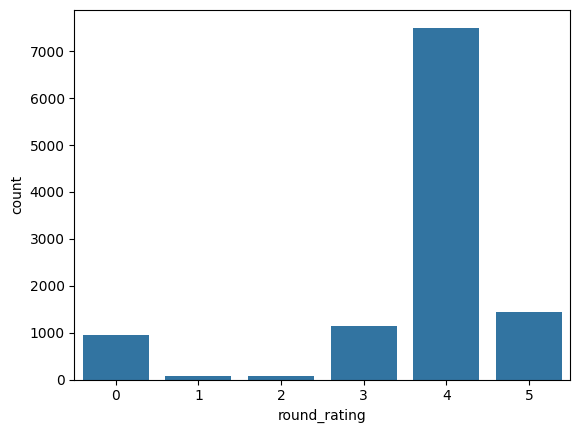

In [28]:
sns.countplot(data=df, x=y_train)

In [29]:
mode_value = y_test.mode().values
naiv_pred = [mode_value for _ in range(len(y_test))]
accuracy_score(y_test, naiv_pred)

0.67

In [30]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', random_state=21, class_weight='balanced', fit_intercept=False)
lr.fit(X=X_train, y=y_train)
y_pred = lr.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.5396428571428571

In [31]:
# 5. Настройка параметров моделей

log_params = {
    'C': [0.1, 1, 10],
    'solver': ['saga'],
    'multi_class': ['ovr'],
    'penalty': ['l2'],
    'max_iter':[10000],
    'fit_intercept':[True],
    'class_weight': [None],
    'tol':[1e-4],
    'random_state': [21]
}

tree_params = {
    'criterion': ['gini'],
    'max_depth': range(5,12),
    'max_features': range(10,20),
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'class_weight': [None],
    'random_state': [21]
}

rf_params = {
    'criterion': ['gini'],
    'n_estimators': [100],
    'max_depth': [46],
    'max_features': [16],
    'min_samples_leaf': [2],
    'min_samples_split':[5],
    'class_weight': [None],
    'bootstrap': [True],
    'random_state': [21]
}

# Создаем экземпляры GridSearchCV
n_jobs = -1

gs_log = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=log_params,
    scoring='accuracy',
    n_jobs=n_jobs
)

gs_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=tree_params,
    scoring='accuracy',
    n_jobs=n_jobs
)


gs_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring='accuracy',
    n_jobs=n_jobs
)

grids = [gs_log, gs_tree, gs_rf]
grid_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest'}


In [34]:
model_selector = ModelSelectionClassification(grids, grid_dict)
best_model = model_selector.choose(X_train, y_train, X_valid, y_valid)
final_model = FinalizeClassification(best_model)
final_score = final_model.final_score(X_train, y_train, X_test, y_test)


Estimator: Logistic Regression


  0%|          | 0/3 [00:00<?, ?it/s]

Best params for Logistic Regression: {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 21, 'solver': 'saga', 'tol': 0.0001}
Validation set accuracy score for best params: 0.679

Estimator: Decision Tree


  0%|          | 0/70 [00:00<?, ?it/s]

Best params for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 21}
Validation set accuracy score for best params: 0.676

Estimator: Random Forest


  0%|          | 0/1 [00:00<?, ?it/s]

Best params for Random Forest: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 46, 'max_features': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 21}
Validation set accuracy score for best params: 0.680

FINAL RESULT:
The best model among all is Random Forest
The best validation set accuracy score is 0.680

Test set accuracy of the final model is 0.682


### 3. Целевые классы: bad, so-so, great

In [32]:
split_processing = Pipeline([
    ('feature_extractor', MyFeatureExtractor('cat_rating')),
    ('data_splitter', TrainValidationTest())
])

X_train, X_valid, X_test, y_train, y_valid, y_test = split_processing.fit_transform(df)
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape), (X_test.shape, y_test.shape)

(((11200, 177), (11200,)), ((2800, 177), (2800,)), ((3500, 177), (3500,)))

<Axes: xlabel='cat_rating', ylabel='count'>

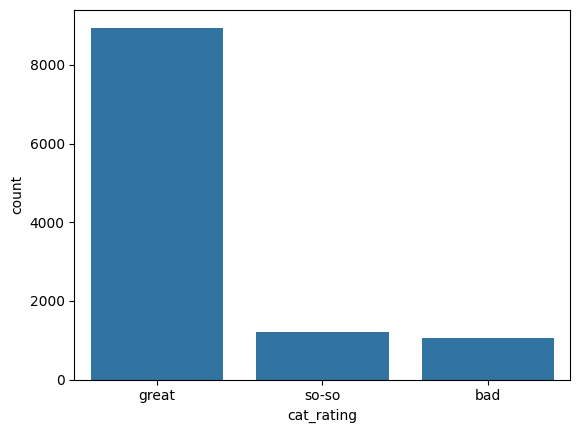

In [33]:
sns.countplot(data=df, x=y_train)

In [34]:
mode_value = y_test.mode().values
naiv_pred = [mode_value for _ in range(len(y_test))]
accuracy_score(y_test, naiv_pred)

0.7988571428571428

In [35]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', random_state=21, class_weight='balanced', fit_intercept=False)
lr.fit(X=X_train, y=y_train)
y_pred = lr.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.76

In [39]:
model_selector = ModelSelectionClassification(grids, grid_dict)
best_model = model_selector.choose(X_train, y_train, X_valid, y_valid)
final_model = FinalizeClassification(best_model)
final_score = final_model.final_score(X_train, y_train, X_test, y_test)


Estimator: Logistic Regression


  0%|          | 0/3 [00:00<?, ?it/s]

Best params for Logistic Regression: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 21, 'solver': 'saga', 'tol': 0.0001}
Validation set accuracy score for best params: 0.804

Estimator: Decision Tree


  0%|          | 0/70 [00:00<?, ?it/s]

Best params for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 21}
Validation set accuracy score for best params: 0.805

Estimator: Random Forest


  0%|          | 0/1 [00:00<?, ?it/s]

Best params for Random Forest: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 46, 'max_features': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 21}
Validation set accuracy score for best params: 0.805

FINAL RESULT:
The best model among all is Decision Tree
The best validation set accuracy score is 0.805

Test set accuracy of the final model is 0.807


### 4. Новая метрика для классификации: precision of the 'great' class

In [36]:
precision_great_score = make_scorer(precision_score,labels=['great'], average='weighted', zero_division=0)

In [37]:
class ModelSelectionPrecision:
    def __init__(self, grids, grid_dict):
        """
        Инициализация класса
        :param grids: список GridSearchCV объектов
        :param grid_dict: словарь с именами моделей
        """
        self.grids = grids
        self.grid_dict = grid_dict
        self.results = []
        self.best_overall_model = None  # Лучшая модель из всех
        self.best_overall_score = 0.0   # Лучший score из всех
        self.best_overall_name = ''     # Имя лучшей модели

    def choose(self, X_train, y_train, X_valid, y_valid):
        for idx in self.grid_dict:
            grid = self.grids[idx]
            model_name = self.grid_dict[idx]
            print(f"\nEstimator: {model_name}")
            
            all_params = list(ParameterGrid(grid.param_grid))
            len_params = len(all_params)
            
            # Инициализируем переменные для текущей модели
            best_model_params = None
            best_model_score = 0.0
            
            for _, params in enumerate(tqdm(all_params, leave=True, total=len_params, unit="it")):
                try:
                    model = clone(grid.estimator)
                    model.set_params(**params)
                    model.fit(X_train, y_train)
                    
                    # Оценка на валидации
                    y_pred = model.predict(X_valid)
                    valid_score = precision_score(y_true=y_valid, y_pred=y_pred,  labels=['great'], average='weighted', zero_division=0)
                    
                    # Обновление лучших параметров для текущей модели
                    if valid_score > best_model_score:
                        best_model_score = valid_score
                        best_model_params = params
                        
                        # Проверка на лучший результат среди всех моделей
                        if valid_score > self.best_overall_score:
                            self.best_overall_score = valid_score
                            self.best_overall_name = model_name
                            self.best_overall_model = model
                            
                except Exception as e:
                    print(f"Ошибка при обучении модели {model_name} с параметрами {params}: {str(e)}")
                    continue
            
            # Вывод результатов для текущей модели
            print(f"Best params for {model_name}: {best_model_params}")
            print(f"Validation set precision_great score for best params: {best_model_score:.3f}")
            
            # Сохранение результатов
            self.results.append({
                'model': model_name,
                'params': best_model_params,
                'valid_score': best_model_score
            })
        
        # Вывод итоговой информации
        print("\nFINAL RESULT:")
        print(f"The best model among all is {self.best_overall_name}")
        print(f"The best validation set presision great score is {self.best_overall_score:.3f}\n")
        
        return self.best_overall_model

    def get_results(self):
        """
        Возвращает DataFrame с результатами всех моделей
        """
        return pd.DataFrame(self.results)[['model', 'params', 'valid_score']]

In [43]:
# 5. Настройка параметров моделей

log_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga','lbfgs'],
    'multi_class': ['ovr'],
    'penalty': ['l2'],
    'max_iter':[10000],
    'fit_intercept':[True],
    'class_weight': ['balanced'],
    'tol':[1e-4],
    'random_state': [21]
}

tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3,10),
    'max_features': [17],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'class_weight': ['balanced'],
    'random_state': [21]
}


rf_params = {
    'criterion': ['gini'],
    'n_estimators': range(50,200,10),
    'max_depth': [6],
    'max_features': [6,7,8,17,19],
    'min_samples_leaf': [2],
    'min_samples_split':[2],
    'class_weight': ['balanced'],
    'bootstrap': [True],
    'random_state': [21]
}

n_jobs = -1

gs_log = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=log_params,
    scoring=precision_great_score,
    n_jobs=n_jobs
)

gs_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=tree_params,
    scoring=precision_great_score,
    n_jobs=n_jobs
)


gs_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring=precision_great_score,
    n_jobs=n_jobs
)

grids = [gs_log, gs_tree, gs_rf]
grid_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest'}


In [44]:
model_selector = ModelSelectionPrecision(grids, grid_dict)
best_model = model_selector.choose(X_train, y_train, X_valid, y_valid)


Estimator: Logistic Regression


  0%|          | 0/8 [00:00<?, ?it/s]

Best params for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 10000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 21, 'solver': 'saga', 'tol': 0.0001}
Validation set precision_great score for best params: 0.869

Estimator: Decision Tree


  0%|          | 0/14 [00:00<?, ?it/s]

Best params for Decision Tree: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'max_features': 17, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 21}
Validation set precision_great score for best params: 0.838

Estimator: Random Forest


  0%|          | 0/75 [00:00<?, ?it/s]

Best params for Random Forest: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80, 'random_state': 21}
Validation set precision_great score for best params: 0.876

FINAL RESULT:
The best model among all is Random Forest
The best validation set presision great score is 0.876



In [44]:
y_pred = best_model.predict(X_test)
precision_score(y_test, y_pred,  labels=['great'], average='weighted', zero_division=0)

0.8603667136812412

### 5. Ансамбли классификаторов
>**Voting Classifier**

In [39]:
def search_best_voting_params(X_train, X_test, y_train, y_test, estimators_list, voting_types, weights_list):
    results = []
    
    # Добавляем параметр zero_division для обработки предупреждений
    # zero_division_param = 0
    
    for voting in tqdm(voting_types, desc="Voting Types"):
        for weights in tqdm(weights_list, desc=f"Weights for {voting}", leave=False):
            try:
                vc = VotingClassifier(
                    estimators=estimators_list,
                    voting=voting,
                    weights=weights,
                    n_jobs=-1
                )
                
                vc.fit(X_train, y_train)
                y_pred = vc.predict(X_test)
                precision = precision_score(y_test, y_pred,  labels=['great'], average='weighted', zero_division=0)

                results.append({
                    'precision great': precision,
                    'params': f"{voting} voting, weights={weights}"
                })
                
            except Exception as e:
                print(f"Ошибка при параметрах {voting}, {weights}: {e}")
                continue
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='precision great',ascending=False).reset_index(drop=True)
    
    return results_df

In [40]:
lr = LogisticRegression(C=10, class_weight='balanced', fit_intercept=True, max_iter=10000, multi_class='ovr', penalty='l2', random_state=21, solver='saga', tol=0.0001)
dt = DecisionTreeClassifier(class_weight='balanced',criterion='gini',max_depth=9, max_features=17,min_samples_leaf=2, min_samples_split=2,random_state=21)
rf = RandomForestClassifier(class_weight='balanced',criterion='gini', max_depth=6, max_features=6, min_samples_leaf=2, min_samples_split=2,n_estimators=80,random_state=21)

In [41]:
estimators_list = [('Logistic Regression', lr), 
                  ('Decision Tree', dt), 
                  ('Random Forest', rf)]

In [42]:
voting_types = ['hard', 'soft']
weights_list = list(product(range(1, 5), repeat=3))

votes_results = search_best_voting_params(X_train,X_valid,y_train,y_valid,estimators_list,voting_types,weights_list)
votes_results.head(7)

Voting Types:   0%|          | 0/2 [00:00<?, ?it/s]

Weights for hard:   0%|          | 0/64 [00:00<?, ?it/s]

Weights for soft:   0%|          | 0/64 [00:00<?, ?it/s]

,precision great,params
0,0.876384,"hard voting, weights=(1, 2, 4)"
1,0.876384,"hard voting, weights=(1, 1, 3)"
2,0.876384,"hard voting, weights=(1, 1, 4)"
3,0.876384,"hard voting, weights=(2, 1, 4)"
4,0.875637,"hard voting, weights=(1, 1, 1)"
5,0.875637,"hard voting, weights=(4, 4, 4)"
6,0.875637,"hard voting, weights=(2, 2, 2)"


>**Bagging Classifier**

In [45]:
n_estimators = range(20,300,10)

In [46]:
def serch_best_bagging_params(X_train,X_test,y_train,y_test,n_estimators):
    results = []
    for n in n_estimators:
        bc = BaggingClassifier(base_estimator=dt, n_estimators=n, bootstrap=True, random_state=21, n_jobs=-1)
        bc.fit(X_train, y_train)
        y_pred = bc.predict(X_test)
                
        precision = precision_score(y_test, y_pred, labels=['great'], average='weighted', zero_division=0)

        results.append({
            'n_estimators': n,
            'precision great': precision
        })
    results = pd.DataFrame(results)
    results = results.sort_values(by='precision great', ascending=False).reset_index(drop=True)
    return results

In [47]:
bagging = serch_best_bagging_params(X_train,X_valid,y_train,y_valid, n_estimators)
bagging.head(3)

,n_estimators,precision great
0,30,0.859696
1,280,0.856287
2,260,0.855925


>**Stacking classifier**

In [48]:
def serch_best_stack_params(X_train,X_test,y_train,y_test,estimators_list,n_list, passth_list):
    results = []

    for passthrough in passth_list:
        for n in n_list:
            skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=21)
            stack_clf = StackingClassifier(
                estimators=estimators_list,
                final_estimator=lr,
                passthrough=passthrough,
                cv=skf,
                n_jobs=-1
                )
            stack_clf.fit(X_train, y_train)
            y_pred = stack_clf.predict(X_test)
            precision = precision_score(y_test, y_pred, labels=['great'], average='weighted', zero_division=0)
                
            results.append({
                'n_splits': n,
                'passthrough': passthrough,
                'precision great': precision
            })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='precision great', ascending=False).reset_index(drop=True)
    return results_df

In [49]:
estimators_list = [('Decision Tree', dt),('Random Forest', rf)]

n_list  = range(2,9)
passth_list = [True, False]
results_df = serch_best_stack_params(X_train,X_valid,y_train,y_valid,estimators_list,n_list,passth_list)
results_df.head(3)

,n_splits,passthrough,precision great
0,4,True,0.869331
1,3,True,0.864071
2,6,True,0.863976


## Decision

| Подход                                       | Метрика     | Наивный | Лучшая модель (валидация) | Лучшая модель (тест) | Соотношение с бейзлайном (тест)      |
| -------------------------------------------- | ----------- | -------- | ------------------------- | -------------------- | ------------------------------------ |
| **Регрессия**                                | RMSE ↓      | 1.304    | 1.228                     | 1.253                | 1.253 / 1.304 = **0.96** (≈4% лучше) |
| **Классификация (округление)**               | Accuracy ↑  | 0.670    | 0.680                     | 0.682                | 0.682 / 0.670 = **1.02** (≈2% лучше) |
| **Классификация (категории)**                | Accuracy ↑  | 0.799    | 0.805                     | 0.807                | 0.807 / 0.799 = **1.01** (≈1% лучше) |
| **Классификация (категории, класс "great")** | Precision ↑ | 0.799        | 0.876                     | 0.860                | 0.860 / 0.799 = **1.076** (≈7,6% лучше)                                   |


🔹 Регрессия (предсказание числового рейтинга) Улучшение по сравнению с наивным есть, но не кардинальное.
   RMSE остаётся выше 1.2, что означает заметную ошибку при предсказании точного числового значения рейтинга.

🔹 Классификация (округлённый рейтинг)
    Есть прирост относительно наивного accuracy.
    Но прирост минимален, модель почти не выигрывает у наивного прогнозирования.

🔹 Классификация по категориальному рейтингу (so-so, bad, great) точность не значитлеьна, но c дополнительной метрикой
    точность выделения класса great
    Модель уверенно выделяет класс great и явно превосходит наивный выбор.

   
 
Таким образом лучшая практическая ценность у модели-классификатора по категориальному рейтингу, особенно по метрике Precision для класса “great” (0.860 на тесте).


###  Финальная модель классификатора

In [50]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=6,
                       min_samples_leaf=2, n_estimators=80, random_state=21)

In [67]:
final_classification = FinalizeClassification(rf)
final_classification.save_model('data/clf.joblib')

Model successfully saved to data/clf.joblib


In [51]:
# !!!!! сохранить вместе с лучшей моделью признаки. Это нужно для вывода мнения I задания
ingredients = X_train.columns.to_list()
dump(ingredients, "data/feature_names.sav")

['data/feature_names.sav']

## Nutrition Facts

In [52]:
len(ingredients)

177

In [53]:
load_dotenv()

False

Сохраняем во временный файл в связи с тем, что очень не стабильное соединение и загружать данные получалось не всегда, чтобы еще раз не загружать ингредиенты, данный код проверяет есть ли они во временном файле raw_ingredients.json и если нет, то только тогда отправляется запрос к АПИ

In [54]:
def load_cache(filename="data/raw_ingredients.json"):
    """Загрузка кеша из файла. Если файла нет — возвращает пустой словарь."""
    if os.path.exists(filename):
        with open(filename, "r", encoding="utf-8") as f:
            return json.load(f)
    else:
        # если нет файла создает пустой
        with open(filename, "w", encoding="utf-8") as f:
            json.dump({}, f, ensure_ascii=False, indent=2)
        return {}

def save_cache(cache, filename="data/raw_ingredients.json"):
    """Сохраняем словарь кеша в JSON файл."""
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(cache, f, ensure_ascii=False, indent=2)

def get_ingredient_nutrients(ingredient, API_KEY):
    """Получает нутриенты для ингредиента."""

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"

    try:
        search_resp = requests.get(
            search_url, 
            params={"query": ingredient, "api_key": API_KEY, "pageSize": 1},
            timeout=10
        )
        search_resp.raise_for_status()
        search_data = search_resp.json()
    
    except Exception as e:
        print(f"Ошибка при поиске ингредиента '{ingredient}': {e}")
        return None
    
    if search_data['totalHits'] == 0:
        print(f'Ингредиент "{ingredient}" не найден в базе данных')
        return None
    
    nutrients = search_data["foods"][0]["foodNutrients"]
    nutrient_dict = {}
    for nutrient in nutrients:
        # print(nutrient)
        name = nutrient.get('nutrientName')
        value = nutrient.get('value')
        unit = nutrient.get('unitName')
        # nutrient_dict[name] = [value, unit]
        nutrient_dict[name] = (value, unit)
        
    return nutrient_dict


def collect_nutrients(ingredients, API_KEY, cache_file="data/raw_ingredients.json"):
    """Собирает нутриенты для списка ингредиентов с кешированием в JSON."""
    cache = load_cache(cache_file)
    updated = False

    for ing in ingredients:
        if ing in cache:
            continue

        nutrients = get_ingredient_nutrients(ing, API_KEY)
        if nutrients:
            cache[ing] = nutrients
            updated = True
            print(f"{ing} добавлен в кеш")
        else:
            print(f"Пропускаем {ing}, нет данных по нутриентам")

    if updated:
        print('Сохраняем в файл')
        save_cache(cache, cache_file)

    return cache

In [55]:
def get_unique_nutrients(ingredients_nutrients_dict):
    """
    Получает множество всех уникальных названий нутриентов
    из словаря вида:
    {ingredient: {nutrient_name: (amount, unit), ...}, ...}
    """
    unique_nutrients = set()
    for nut_dict in ingredients_nutrients_dict.values():
        unique_nutrients.update(nut_dict.keys())
    return list(unique_nutrients)

In [80]:
API_KEY = os.getenv("API_KEY")

In [85]:
raw_ingredients = collect_nutrients(ingredients, API_KEY)

In [86]:
empty_ings = [ing for ing, nutrients in raw_ingredients.items() if not nutrients]
print(f"Количество ингредиентов без данных: {len(empty_ings)}")
print("Список таких ингредиентов:", empty_ings[:20])  # первые 20

Количество ингредиентов без данных: 0
Список таких ингредиентов: []


In [87]:
print(len(raw_ingredients))

177


Смотрим ингредиенты, которые не удалось загрузить через АПИ missing_in_dict, если такие ингредиенты есть, то нужно еще раз вызвать функцию collect_nutrients(ingredients, API_KEY)

In [88]:
missing_in_dict = [ing for ing in ingredients if ing not in raw_ingredients]
print("Не загрузились в raw_ingredients:", missing_in_dict)

Не загрузились в raw_ingredients: []


In [89]:
uniq_nutrients = get_unique_nutrients(raw_ingredients)
len(uniq_nutrients)

151

Из скаченных уникальных названий нутриентов отберем только те что есть в таблицах в ТЗ
 https://drive.google.com/file/d/1jn0t5tU_RgOpq4wcO-uS4D0_NAP6MwHz/view 
 или 
 здесь https://drive.google.com/file/d/1bmdZGB0QwND2BD3XlC1JswL7AdnTJHLT/view

In [90]:
# Нужные нутриенты для БД с дневной нормой и единицей измерения
DAILY_VALUES = {
    "Total Fat": {"dv": 78, "unit": "g"},
    "Saturated Fat": {"dv": 20, "unit": "g"},
    "Cholesterol": {"dv": 300, "unit": "mg"},
    "Carbohydrate": {"dv": 275, "unit": "g"},
    "Sodium": {"dv": 2300, "unit": "mg"},
    "Fiber": {"dv": 28, "unit": "g"},
    "Sugar": {"dv": 50, "unit": "g"},
    "Protein": {"dv": 50, "unit": "g"},
    "Vitamin A": {"dv": 900, "unit": "mcg"},
    "Vitamin C": {"dv": 90, "unit": "mg"},
    "Calcium": {"dv": 1300, "unit": "mg"},
    "Iron": {"dv": 18, "unit": "mg"},
    "Vitamin D": {"dv": 20, "unit": "mcg"},
    "Vitamin E": {"dv": 15, "unit": "mg"},
    "Vitamin K": {"dv": 120, "unit": "mcg"},
    "Thiamin": {"dv": 1.2, "unit": "mg"},
    "Riboflavin": {"dv": 1.3, "unit": "mg"},
    "Niacin": {"dv": 16, "unit": "mg"},
    "Vitamin B6": {"dv": 1.7, "unit": "mg"},
    "Folate": {"dv": 400, "unit": "mcg"},
    "Vitamin B12": {"dv": 2.4, "unit": "mcg"},
    "Biotin": {"dv": 30, "unit": "mcg"},
    "Pantothenic Acid": {"dv": 5, "unit": "mg"},
    "Phosphorus": {"dv": 1250, "unit": "mg"},
    "Iodine": {"dv": 150, "unit": "mcg"},
    "Magnesium": {"dv": 420, "unit": "mg"},
    "Zinc": {"dv": 11, "unit": "mg"},
    "Selenium": {"dv": 55, "unit": "mcg"},
    "Copper": {"dv": 0.9, "unit": "mg"},
    "Manganese": {"dv": 2.3, "unit": "mg"},
    "Chromium": {"dv": 35, "unit": "mcg"},
    "Molybdenum": {"dv": 45, "unit": "mcg"},
    "Chloride": {"dv": 2300, "unit": "mg"},
    "Potassium": {"dv": 4700, "unit": "mg"},
    "Choline": {"dv": 550, "unit": "mg"},
}

In [91]:
def convert_to_etalon_units(etalon_unit:str, nutrient_name: str, value: float, unit: str) -> (float, str):
    """
    Функция проверяет соответсвие эталонных единиц измерения с данными ингредиента. Если отличается, то пересчитывает знаение и приводит к соответсвию с эталонным.
    """
    unit = unit.lower()
    if etalon_unit == unit:
        return value, unit

    if unit == "µg" or unit == "ug":
        unit = "mcg"
    
    if etalon_unit == "mcg" and unit == "iu":
        # print(nutrient_name, 'Nutrietn name')
        if nutrient_name == "Vitamin A":
            value = value * 0.3
            unit = "mcg"
        elif nutrient_name == "Vitamin D":
            value = value * 0.025
            unit = "mcg"

    if unit != etalon_unit:
        print(f"[!] {nutrient_name}: ({value}{unit}) "
                f"≠ эталон {etalon_unit}")
    return value, unit

In [92]:
ALIASES = {
    "Total Fat": ["Total lipid (fat)"],
    "Saturated Fat": ["Fatty acids, total saturated"],
    "Vitamin B6": ["Vitamin B-6"],
    "Vitamin B12": ["Vitamin B-12", "Vitamin B-12, added"],
    # "Vitamin E": ["Vitamin E, added", "Vitamin E (alpha-tocopherol)"]
}


def find_match(etalon_name: str, nutrients: dict):
    """
    Ищет значение нутриента по эталонному имени.
    Возвращает кортеж: (etalon_name, value, unit)
    """
    # Сначала ищет по алиасам и проверят чтоб value был не 0,
    # иногда бывает что у ингридента 2 похожих нутриента как в ALIASES, чтобы забрать значение где не 0
    if etalon_name in ALIASES:
        for alias in ALIASES[etalon_name]:
            for raw_name, (value, unit) in nutrients.items():
                if alias.lower() in raw_name.lower() and value != 0:
                    return etalon_name, value, unit
        # если все 0, берём первый алиас
        for alias in ALIASES[etalon_name]:
            for raw_name, (value, unit) in nutrients.items():
                if alias.lower() in raw_name.lower():
                    return etalon_name, value, unit

    # потом обычная регулярка по самому названию
    etalon_low = etalon_name.lower()
    for raw_name, (value, unit) in nutrients.items():
        if etalon_low in raw_name.lower() and value != 0:
            return etalon_name, value, unit
    # если всё равно 0
    for raw_name, (value, unit) in nutrients.items():
        if etalon_low in raw_name.lower():
            return etalon_name, value, unit

    return None


def filter_to_etalon(raw_ingredients: dict) -> dict:
    """
    Фильтрует нутриенты у ингредиентов и оставляет только те, которые есть в эталоном варианте DAILY_VALUES.
    """
    result = {}
    for ing, nutrients in raw_ingredients.items():
        mapped = {}
        for etalon_name, etalon_info in DAILY_VALUES.items():
            match = find_match(etalon_name, nutrients)
            if match:
                etalon_name, value, unit = match
                value, unit = convert_to_etalon_units(etalon_info["unit"], etalon_name, value, unit)
                mapped[etalon_name] = (value, unit)
            else:
                mapped[etalon_name] = (0, etalon_info["unit"])
        # if mapped:
        result[ing] = mapped
    return result


In [93]:
filtered = filter_to_etalon(raw_ingredients)

### Перевод значений нутриентов в суточную норму

In [94]:
def calculate_percent_dv(filtered_ingredients: dict, daily_values: dict, output_csv: str):
    """
    Функция считает суточную норму нутриена, в %
    и сохраняет данные в файл csv.
    filtered_ingredients: словарь {ingredient: {nutrient: (value, unit)}}
    daily_values: словарь DAILY_VALUES
    output_csv: путь к CSV файлу
    """
    rows = []
    for ing, nutrients in filtered_ingredients.items():
        row = {"Ingredient": ing}
        for nut_name, (value, unit) in nutrients.items():
            dv = daily_values[nut_name]["dv"]
            percent = round((value / dv) * 100, 2) if dv != 0 else 0
            row[nut_name] = percent
        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    return df

In [95]:
df_nutrients = calculate_percent_dv(filtered, daily_values=DAILY_VALUES, output_csv="data/ingredient_nutrient_dv.csv")

In [96]:
df_nutrients.head()

,Ingredient,Total Fat,Saturated Fat,Cholesterol,Carbohydrate,Sodium,Fiber,Sugar,Protein,Vitamin A,...,Magnesium,Zinc,Selenium,Copper,Manganese,Chromium,Molybdenum,Chloride,Potassium,Choline
0,bacon,64.10,89.50,23.67,0.00,34.17,0.00,0.0,14.28,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
1,banana,8.01,0.00,0.00,14.76,25.83,22.14,12.5,25.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
2,basil,119.62,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
3,beef,7.54,20.60,17.67,0.00,9.22,0.00,0.0,40.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00
4,beet,0.10,0.07,0.00,5.92,6.48,2.86,22.1,1.60,0.22,...,3.57,2.36,1.82,12.89,0.0,0.0,0.0,0.0,2.45,2.73


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, Lentil, Apple, and Turkey Wrap  to Baked Ham with Marmalade-Horseradish Glaze 
Columns: 180 entries, rating to cat_rating
dtypes: float64(178), int64(1), object(1)
memory usage: 24.7+ MB


In [104]:
df.head()

,rating,almond,anise,apple,apricot,artichoke,arugula,asparagus,avocado,bacon,...,watercress,wheat,white wine,wine,wok,yogurt,zucchini,turkey,round_rating,cat_rating
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,so-so
Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great
Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great
Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,great
Spinach Noodle Casserole,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,so-so


## Similar Recipes

Для каждого рецепта из набора данных получим URL-адрес с сайта epicurious.com с подробной информацией (если URL-адреса для этого рецепта нет, пропускает).


In [33]:
df_with_link = df.copy()

In [34]:
if 'recipe_link' not in df_with_link.columns:
    df_with_link['recipe_link'] = np.nan

In [35]:
df_with_link.head()

,rating,almond,anise,apple,apricot,artichoke,arugula,asparagus,avocado,bacon,...,wheat,white wine,wine,wok,yogurt,zucchini,turkey,round_rating,cat_rating,recipe_link
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,so-so,NaN
Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great,NaN
Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great,NaN
Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,great,NaN
Spinach Noodle Casserole,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,so-so,NaN


In [36]:
df_with_link['recipe_link'].isna().sum()

17500

In [61]:
def normalize_string(s):
    # убирает диакритические знаки, приводит к нижнему регистру
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ASCII', 'ignore').decode('utf-8')
    s = s.lower()
    s = re.sub(r'[^a-z0-9 \-]+', '', s)
    return s

def normalize_href(s):
    # убирает диакритические знаки, приводит к нижнему регистру ссылку
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ASCII', 'ignore').decode('utf-8')
    return s.lower()

In [62]:
async def fetch(session, url):
    headers = {"User-Agent": "Mozilla/5.0"}
    async with session.get(url, headers=headers) as response:
        return await response.text()

async def get_recipe_link_async(query, session):
    """Функция получает ссылку на рецепт"""
    url = f"https://www.epicurious.com/search?q={query}"
    try:
        html = await fetch(session, url)
        soup = BeautifulSoup(html, "lxml")
        recipes = []
        for card in soup.select("div[class*='search_result_item-']"):
            link = card.select_one("a[href^='/recipes/food/views/']")
            if link:
                title = link.get_text(strip=True)
                href = "https://www.epicurious.com" + link["href"]
                recipes.append((title, href))
        if not recipes:
            return None
        else:
            query_pattern = "-".join(normalize_string(query).split())
            pattern = re.compile(re.escape(query_pattern))
            for title, href in recipes:
                if pattern.search(normalize_href(href)):
                    print('Aded to file:', pattern, href)
                    return href
            # return recipes[0][1]
            return None
    except Exception as e:
        print(f"Ошибка при обработке '{query}': {e}")
        return None

async def update_recipe_links(df, batch_size=20):
    """Обновляет переданный датафрейм перезаписывает в него ссылку на рецепт."""
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(df.index), batch_size):
            batch = df.index[i:i+batch_size]
            tasks = []
            titles_to_update = []

            for title in batch:
                if pd.notna(df.at[title, 'recipe_link']):
                    continue
                tasks.append(get_recipe_link_async(title, session))
                titles_to_update.append(title)

            if not tasks:
                continue

            results = await asyncio.gather(*tasks, return_exceptions=True)

            for title, result in zip(titles_to_update, results):
                if isinstance(result, Exception):
                    print(f"Ошибка при обработке '{title}': {result}")
                else:
                    df.at[title, 'recipe_link'] = result

            # сохраняем после каждого батча
            df.to_csv("data/recipes_with_links_partial.csv")

In [63]:
csv_path = "data/recipes_with_links.csv"

if os.path.exists(csv_path):
    existed_df_with_link = pd.read_csv(csv_path, index_col=0)

    filled_count = existed_df_with_link['recipe_link'].notna().sum()
    total = len(existed_df_with_link)

    print(f"Собрано {filled_count} из {total} ссылок")

    if filled_count < 14090:  # есть ещё пропуски 14090 удалось собрать максимально
        print("Продолжаем парсинг...")
        nest_asyncio.apply()
        await update_recipe_links(existed_df_with_link, batch_size=50)
        df_with_link = existed_df_with_link
    else:
        print("Собранно достаточно ссылок более 14000, используем готовый файл.")
        df_with_link = existed_df_with_link
else:
    print("Файл не найден, начинаем парсинг с нуля.")
    nest_asyncio.apply()
    await update_recipe_links(df_with_link, batch_size=50)

Собрано 14090 из 17500 ссылок
Собранно достаточно ссылок более 14000, используем готовый файл.


In [64]:
df_with_link['recipe_link'].notna().sum()

14090

Сохраняем новый фрейм данных в CSV-файле, который будет использова в основной программе.

In [56]:
df_with_link.to_csv("data/recipes_with_links.csv")

In [42]:
df_with_link.head()

,rating,almond,anise,apple,apricot,artichoke,arugula,asparagus,avocado,bacon,...,wheat,white wine,wine,wok,yogurt,zucchini,turkey,round_rating,cat_rating,recipe_link
title,,,,,,,,,,,,,,,,,,,,,
"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,so-so,https://www.epicurious.com/recipes/food/views/...
Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great,https://www.epicurious.com/recipes/food/views/...
Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,great,https://www.epicurious.com/recipes/food/views/...
Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,great,https://www.epicurious.com/recipes/food/views/...
Spinach Noodle Casserole,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,so-so,NaN


## Подготовка данных для бонусной части

Добавим в последний датафрейм колонки 'breakfast', 'lunch', 'dinner' из первичной таблицы. Создадим новый датафрейм. Также удалим строки, которые не содержат recipe_link, так они все равно не понадобятся. Полученный датафрей сохраняем в csv файл, который будет использоваться в  nutritionist.py

In [86]:
old_df = pd.read_csv('data/epi_r.csv', encoding='utf-8')
linked_df = df_with_link.copy()
linked_df = linked_df[linked_df['recipe_link'].notna()]

In [87]:
meal_cols = ['title', 'breakfast', 'lunch', 'dinner']
meal_df = old_df[meal_cols].copy()
meal_df = meal_df.drop_duplicates(subset=['title'])

In [88]:
clean_df_reset = linked_df.reset_index()

In [89]:
clean_df_reset.shape

(14090, 182)

In [90]:
bonus_df = clean_df_reset.merge(
    meal_df,
    on='title',
    how='left'
)

In [91]:
bonus_df = bonus_df.set_index('title')

print("Размерность merged_df:", bonus_df.shape)
print(bonus_df[['breakfast', 'lunch', 'dinner']].sum())

Размерность merged_df: (14090, 184)
breakfast     573.0
lunch        1083.0
dinner       2205.0
dtype: float64


In [92]:
bonus_df.to_csv("data/recipes_bonus.csv")